# Healthcare Insurance Premium Prediction  
### Notebook 05a — Model Training for Rest Segment (Age > 25)

This notebook trains a dedicated premium prediction model for customers aged above 25.

#### **Key Steps**
- Apply data cleaning, EDA, and feature engineering outputs to the rest dataset 
- Train multiple ML models and compare performance  
- Perform hyperparameter tuning  
- Conduct error analysis for the rest population  
- Export:
  - Rest-segment model
  - Associated scaler and feature list

This model serves all users aged >25 in the deployed Streamlit application.

In [1]:
# Import necessary libraries
from imports import *

## Data Preparation and Exploration

In [2]:
# Import the dataset and display the first few rows

df_rest = pd.read_excel("../data/processed/premiums_rest.xlsx")

print("Number of rows and columns: ", df_rest.shape)

print("First few rows of the dataset:")
df_rest.head(3)

Number of rows and columns:  (29904, 13)
First few rows of the dataset:


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
# Clean column names for consistency (replace spaces, lowercase all)

df_rest.columns = df_rest.columns.str.replace(' ', '_').str.lower()
df_rest.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


## Handling Missing Values

In [4]:
# Check for any missing values in the dataset and handle them appropriately
print("Missing values in the dataset:")
print(df_rest.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64


In [5]:
# Drop rows with missing values
df_rest.dropna(inplace=True)

In [6]:
print("Missing values in the dataset:")
print(df_rest.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64


## Checking for Duplicate Records

In [7]:
# Check for any duplicate values in the dataset and handle them appropriately
print("Duplicate values in the dataset:")
print(df_rest.duplicated().sum())

# if duplicate values are found:
df_rest.drop_duplicates(inplace=True)
print("Duplicate values in the dataset:")
print(df_rest.duplicated().sum())

Duplicate values in the dataset:
0
Duplicate values in the dataset:
0


## Summary Statistics of Numerical Features

In [8]:
# Generate quick summary statistics for all numeric columns
df_rest.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


### Investigating Invalid Values in 'number_of_dependants'

In [9]:
# Check for invalid dependant counts (negative values)
print(df_rest[df_rest.number_of_dependants<0]['number_of_dependants'].unique())
print(df_rest[df_rest.number_of_dependants<0].shape)

[-1 -3]
(50, 13)


In [10]:
# Correct negative dependant counts by taking absolute values
df_rest['number_of_dependants'] = abs(df_rest['number_of_dependants'])

# Verifying the updated distribution
df_rest['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

### Outlier Detection

In [11]:
# Extract all numeric columns (integers and floats)
numeric_columns_rest = df_rest.select_dtypes(['float64', 'int64']).columns
numeric_columns_rest

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

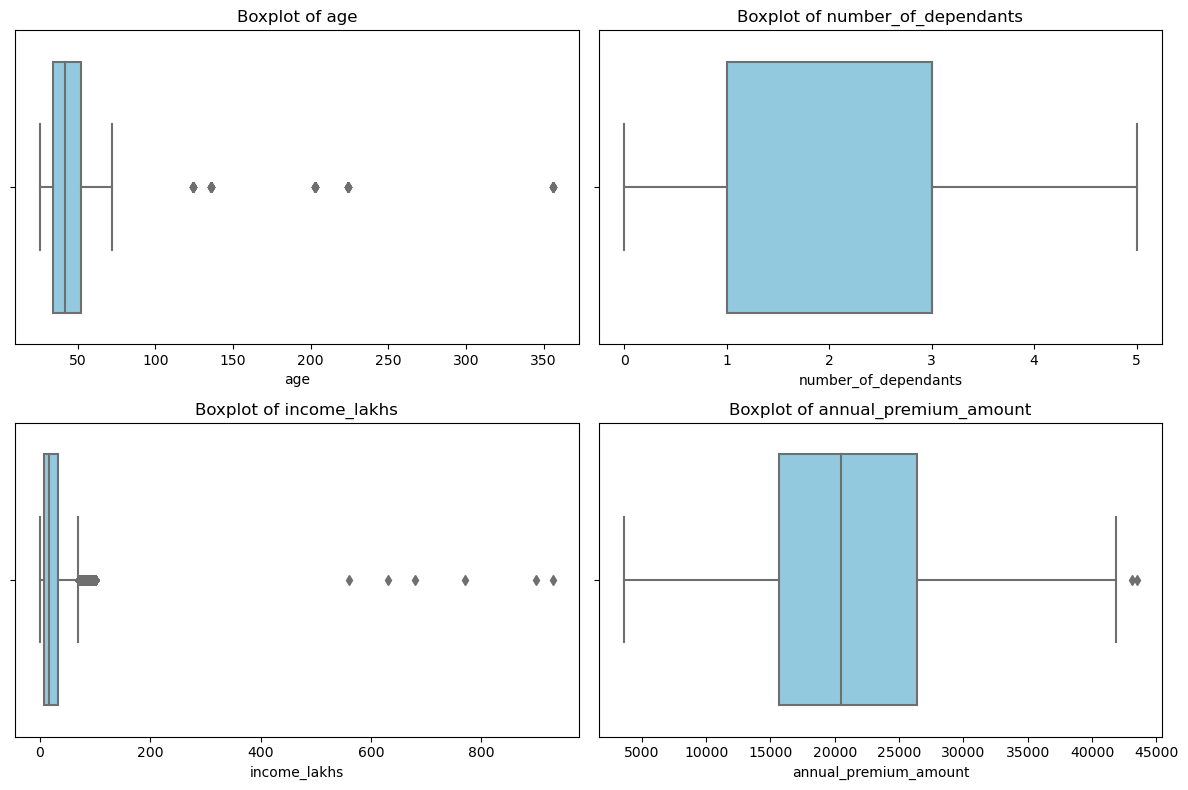

In [12]:
# Visualize outliers for all numeric columns using boxplots
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten so we can loop easily

for i, col in enumerate(numeric_columns_rest):
    sns.boxplot(x=df_rest[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/numeric_boxplots_grid.png", dpi=300)
plt.show()

### Outlier Treatment

#### For Age:

In [13]:
# Identify unrealistic age values (>100)
print(df_rest[df_rest.age>100]['age'].shape)
print(df_rest[df_rest.age>100]['age'].unique())

(58,)
[224 124 136 203 356]


In [14]:
# Drop these outliers
# Storing the cleaned data in a new DataFrame for reproducibility
df1_rest = df_rest[df_rest.age<=100].copy()

# Verify the cleaned data
df1_rest.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


#### For Income:

In [15]:
# Define a function to compute IQR bounds
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check IQR-based bounds
lower, upper = get_iqr_bounds(df1_rest['income_lakhs'])
print(f"IQR bounds: lower={lower}, upper={upper}")

IQR bounds: lower=-30.5, upper=69.5


In [16]:
# using quantile thresholds
for q in [0.9, 0.99, 0.999]:
    print(f"{int(q*100)}th percentile:", df1_rest['income_lakhs'].quantile(q))

90th percentile: 56.0
99th percentile: 96.0
99th percentile: 100.0


In [17]:
# Set an upper threshold of 100L (≈₹1 crore) as the cutoff
quantile_threshold = 100
print("Records above threshold:", df1_rest[df1_rest['income_lakhs'] > quantile_threshold].shape)

Records above threshold: (6, 13)


In [18]:
# Display high-income outlier records (for reference)
high_income_outliers_rest = df1_rest[df1_rest['income_lakhs'] > quantile_threshold]
display(high_income_outliers_rest)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
1598,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4657,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
5399,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
6149,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
21176,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
24489,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


## Distribution Analysis for Numerical Features:

In [19]:
# Drop extreme high-income outliers and save to a new dataframe
df2_rest = df1_rest[df1_rest['income_lakhs'] <= quantile_threshold].copy()

# Verify shape and descriptive stats post-cleaning
print("Cleaned dataset shape:", df2_rest.shape)
df2_rest.describe()

Cleaned dataset shape: (29822, 13)


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


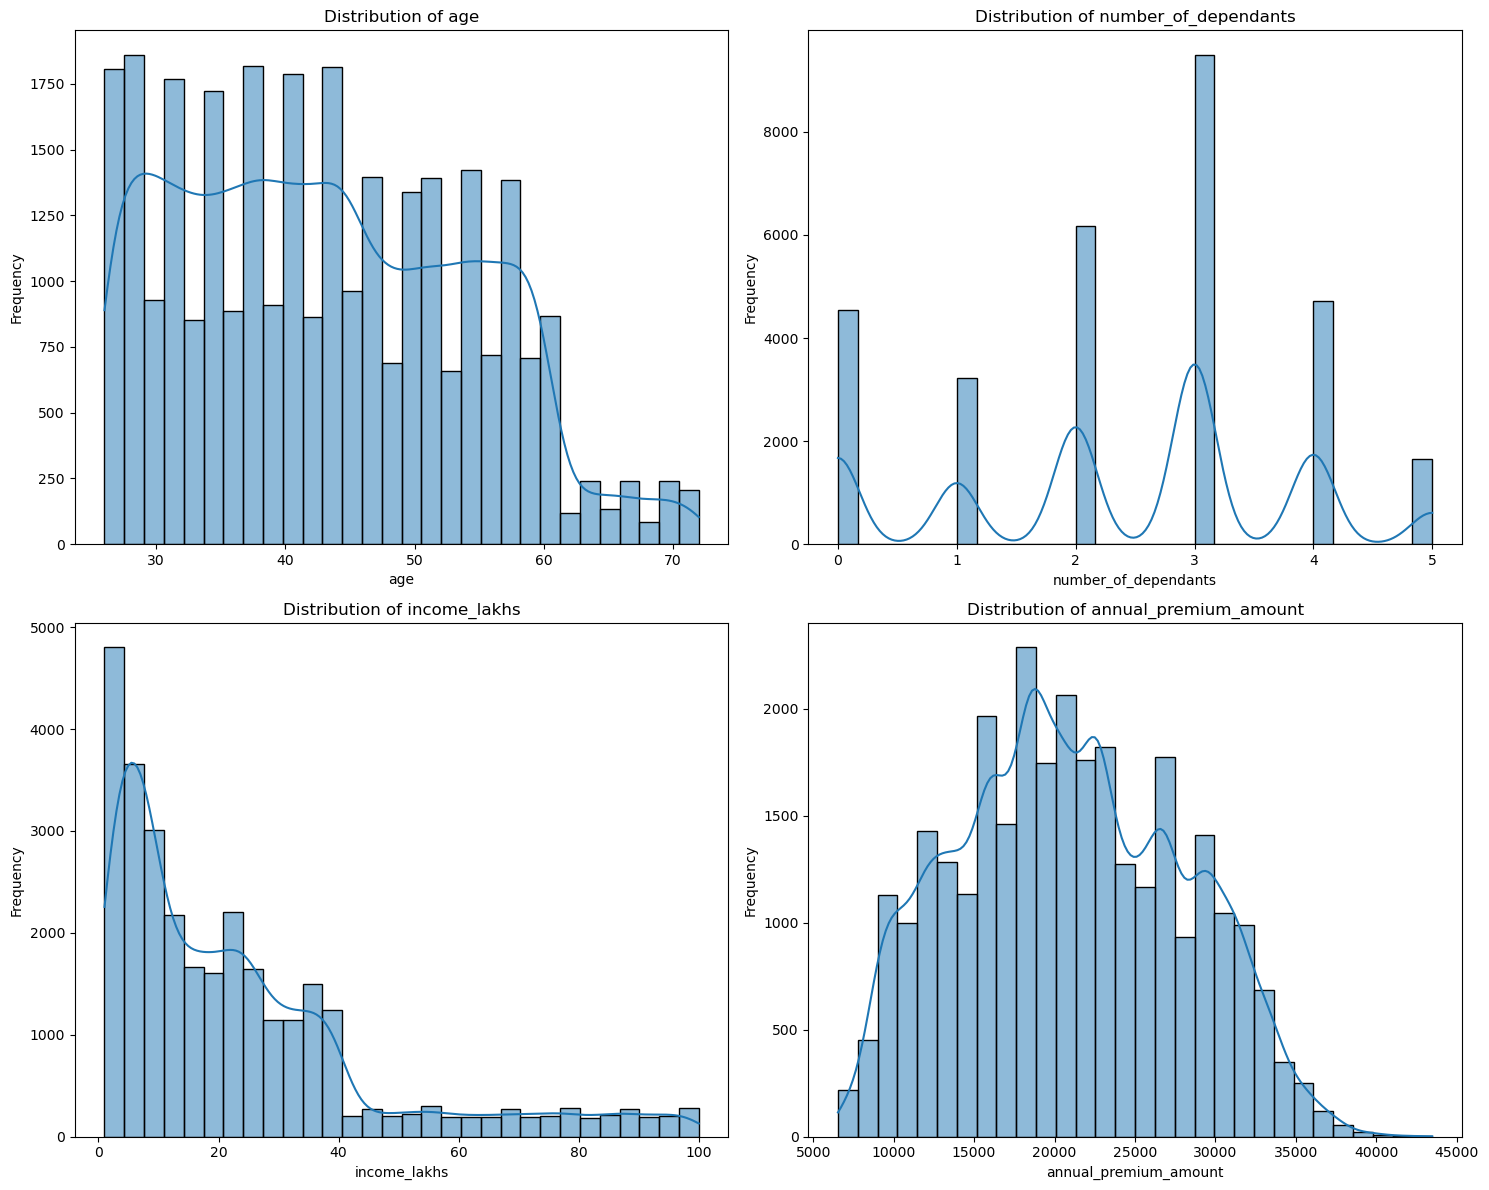

In [20]:
# Plot histograms for all numeric columns to examine data distribution and skewness
plt.figure(figsize=(15,12))

for i, col in enumerate(numeric_columns_rest, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df2_rest[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/numeric_univariate_distribution_grid.png", dpi=300)
plt.show()

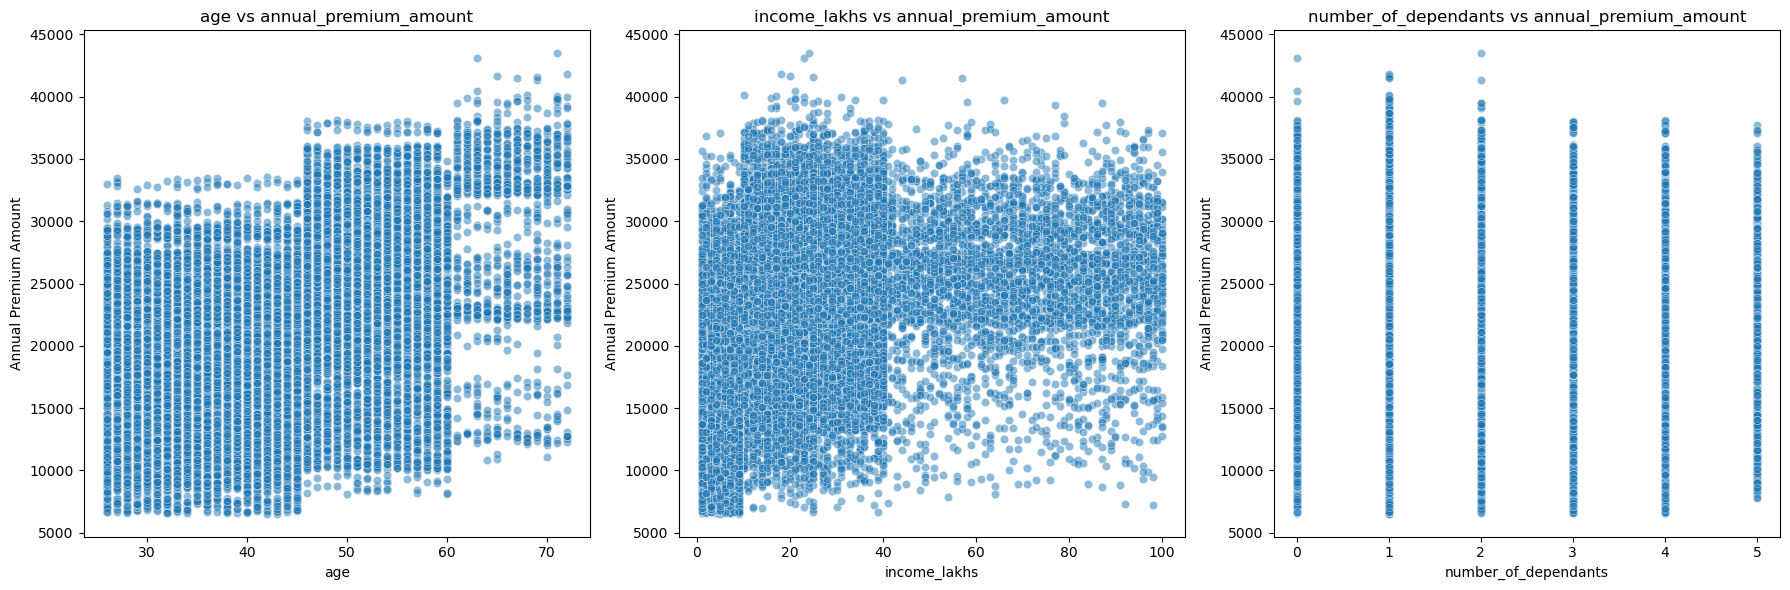

In [21]:
# Scatter plot grid to examine relationships between numeric features and annual premium
plt.figure(figsize=(18, 6))

numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df2_rest[col], y=df2_rest['annual_premium_amount'], alpha=0.5)
    plt.title(f'{col} vs annual_premium_amount')
    plt.xlabel(col)
    plt.ylabel('Annual Premium Amount')

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/numeric_bivariate_scatter_grid.png", dpi=300)
plt.show()

## Distribution Analysis for Categorical Features:

In [22]:
# Select categorical columns
categorical_columns = df2_rest.select_dtypes(['object']).columns
# Check unique values in categorical columns to identify inconsistencies
for col in categorical_columns:
    print(col, ":", df2_rest[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [23]:
# Standardizing inconsistent 'smoking_status' entries
# Merge multiple variants representing non-smokers into a single label: 'No Smoking'
df2_rest['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking'
}, inplace=True)

# Verifying that values are now consistent
df2_rest['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

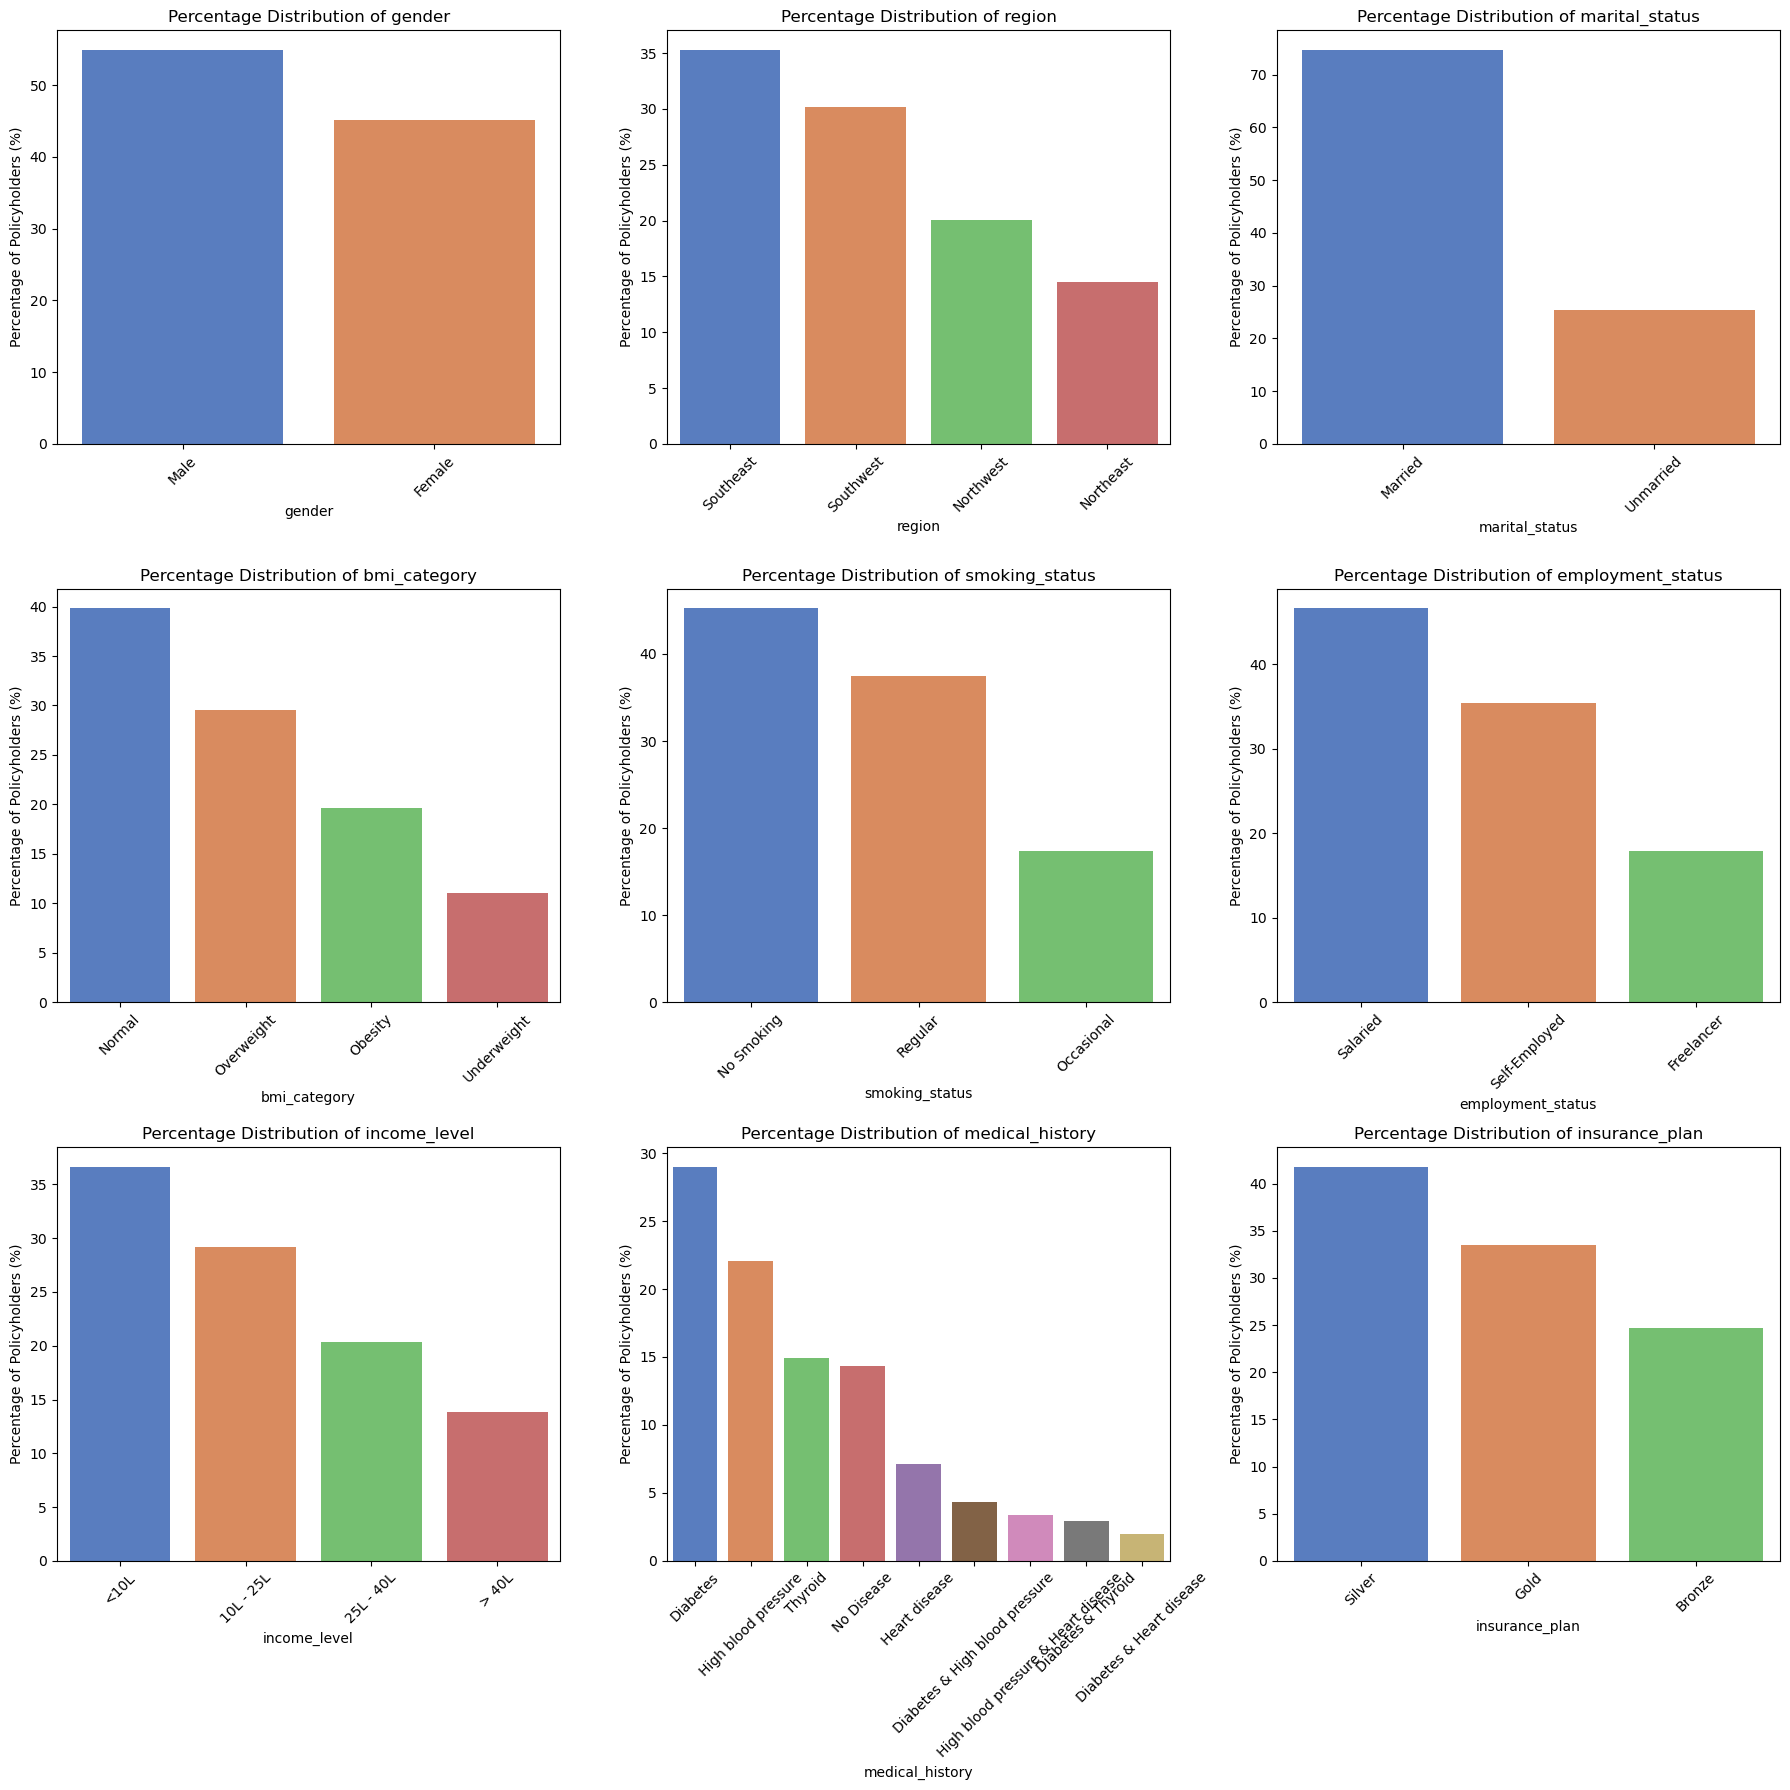

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    category_counts = df2_rest[col].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i], palette='muted')
    axes[i].set_title(f'Percentage Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/categorical_univariate_distribution_grid.png", dpi=300)
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


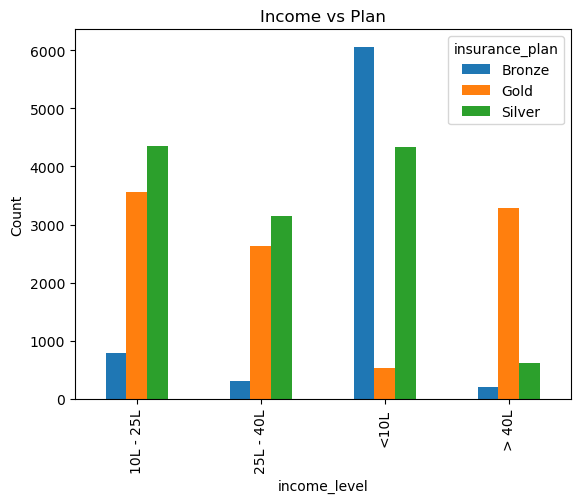

In [25]:
crosstab = pd.crosstab(df2_rest['income_level'], df2_rest['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.savefig("../outputs/figures/premiums_rest/income_vs_plan_bar.png", dpi=300)
plt.show()

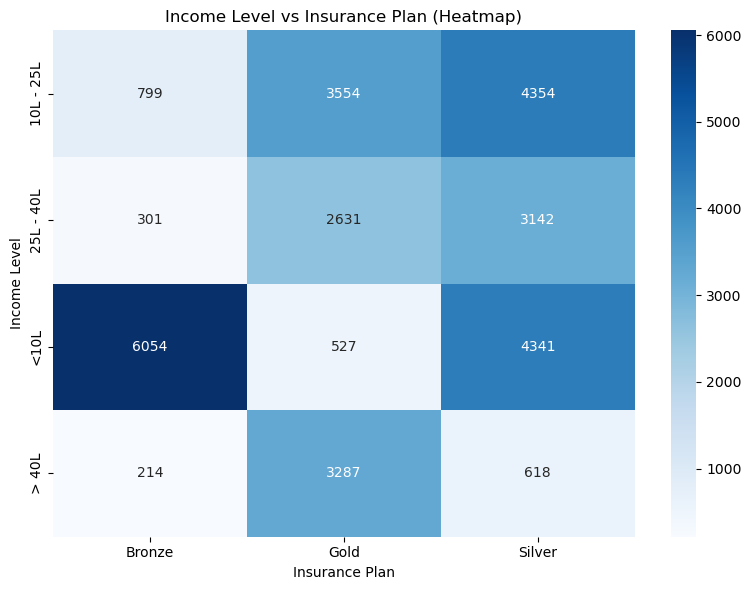

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Income Level vs Insurance Plan (Heatmap)')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/income_vs_plan_heatmap.png", dpi=300)
plt.show()

<h2>Feature Engineering</h2>

In [27]:
df2_rest.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [28]:
# Define risk scores for each medical condition
# Each disease is assigned a base risk score reflecting its relative severity:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [29]:
# Split combined conditions (e.g., "Diabetes & Heart disease") into separate columns
# convert all text to lowercase for consistency
df2_rest[['disease1', 'disease2']]= df2_rest['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

df2_rest.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [30]:
# Replace missing entries with 'none' to handle single-condition or empty cases
df2_rest['disease1'].fillna('none', inplace=True)
df2_rest['disease2'].fillna('none', inplace=True)

# Initialize a new column for total risk score
df2_rest['total_risk_score'] = 0

# Add up risk scores from both disease columns
for disease in ['disease1', 'disease2']:
    df2_rest['total_risk_score'] += df2_rest[disease].map(risk_scores)

In [31]:
# Normalize the total risk score between 0 and 1 for model compatibility
max_score = df2_rest['total_risk_score'].max()
min_score = df2_rest['total_risk_score'].min()

df2_rest['normalized_risk_score'] = (df2_rest['total_risk_score'] - min_score) / (max_score - min_score)

# Preview transformed features
df2_rest.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


### Ordinal Encoding for Ordered Categorical Variables

In [32]:
# Inspect unique values in the insurance_plan column
df2_rest.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [33]:
# Encode ordinal relationship: Bronze < Silver < Gold
df2_rest['insurance_plan'] = df2_rest['insurance_plan'].map({
    'Bronze': 1, 'Silver': 2, 'Gold': 3
})

# Verify encoded values
df2_rest.insurance_plan.unique()

array([1, 2, 3])

In [34]:
# Encode ascending income levels
df2_rest['income_level'] = df2_rest['income_level'].map({
    '<10L': 1, '10L - 25L': 2, '25L - 40L': 3,'> 40L': 4 
})

In [35]:
# Inspect unique values in the bmi_category column
df2_rest['bmi_category'].unique()

array(['Normal', 'Obesity', 'Overweight', 'Underweight'], dtype=object)

In [36]:
# Encode ascending bmi categories
df2_rest['bmi_category'] = df2_rest['bmi_category'].map({
    'Underweight': 1, 'Normal': 2, 'Overweight': 3,'Obesity': 4 
})

In [37]:
# Preview the updated dataset
df2_rest.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,2,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,4,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,2,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571


### One-Hot Encoding for Nominal Categorical Variables 

In [38]:
# Define nominal categorical columns for one-hot encoding
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']

# Apply one-hot encoding using pandas get_dummies
# drop_first=True → drops one column per feature to avoid multicollinearity
# dtype=int → ensures the new columns are integer (0/1) instead of boolean
df3_rest = pd.get_dummies(df2_rest, columns=nominal_cols, drop_first=True, dtype=int)

In [39]:
df3_rest.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,Diabetes,1,9053,diabetes,none,...,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,Diabetes,1,16339,diabetes,none,...,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,High blood pressure,2,18164,high blood pressure,none,...,0.428571,0,0,0,0,0,0,0,0,1


In [40]:
# Drop redundant or intermediate columns after feature engineering
# - 'medical_history' (raw text column)
# - 'disease1' (temporary helper column)
# - 'disease2' (temporary helper column)
# - 'total_risk_score' (unscaled version of normalized score)
df4_rest = df3_rest.drop(['medical_history', 'disease1', 'disease2','total_risk_score'], axis=1)

# Verify the resulting dataframe
df4_rest.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,1,9053,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,1


In [41]:
# Convert all column names to lowercase for consistency
df4_rest.columns = df4_rest.columns.str.lower()

# Verify the resulting dataframe
df4_rest.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,26,0,2,1,6,1,9053,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,1


### Feature Correlation Analysis

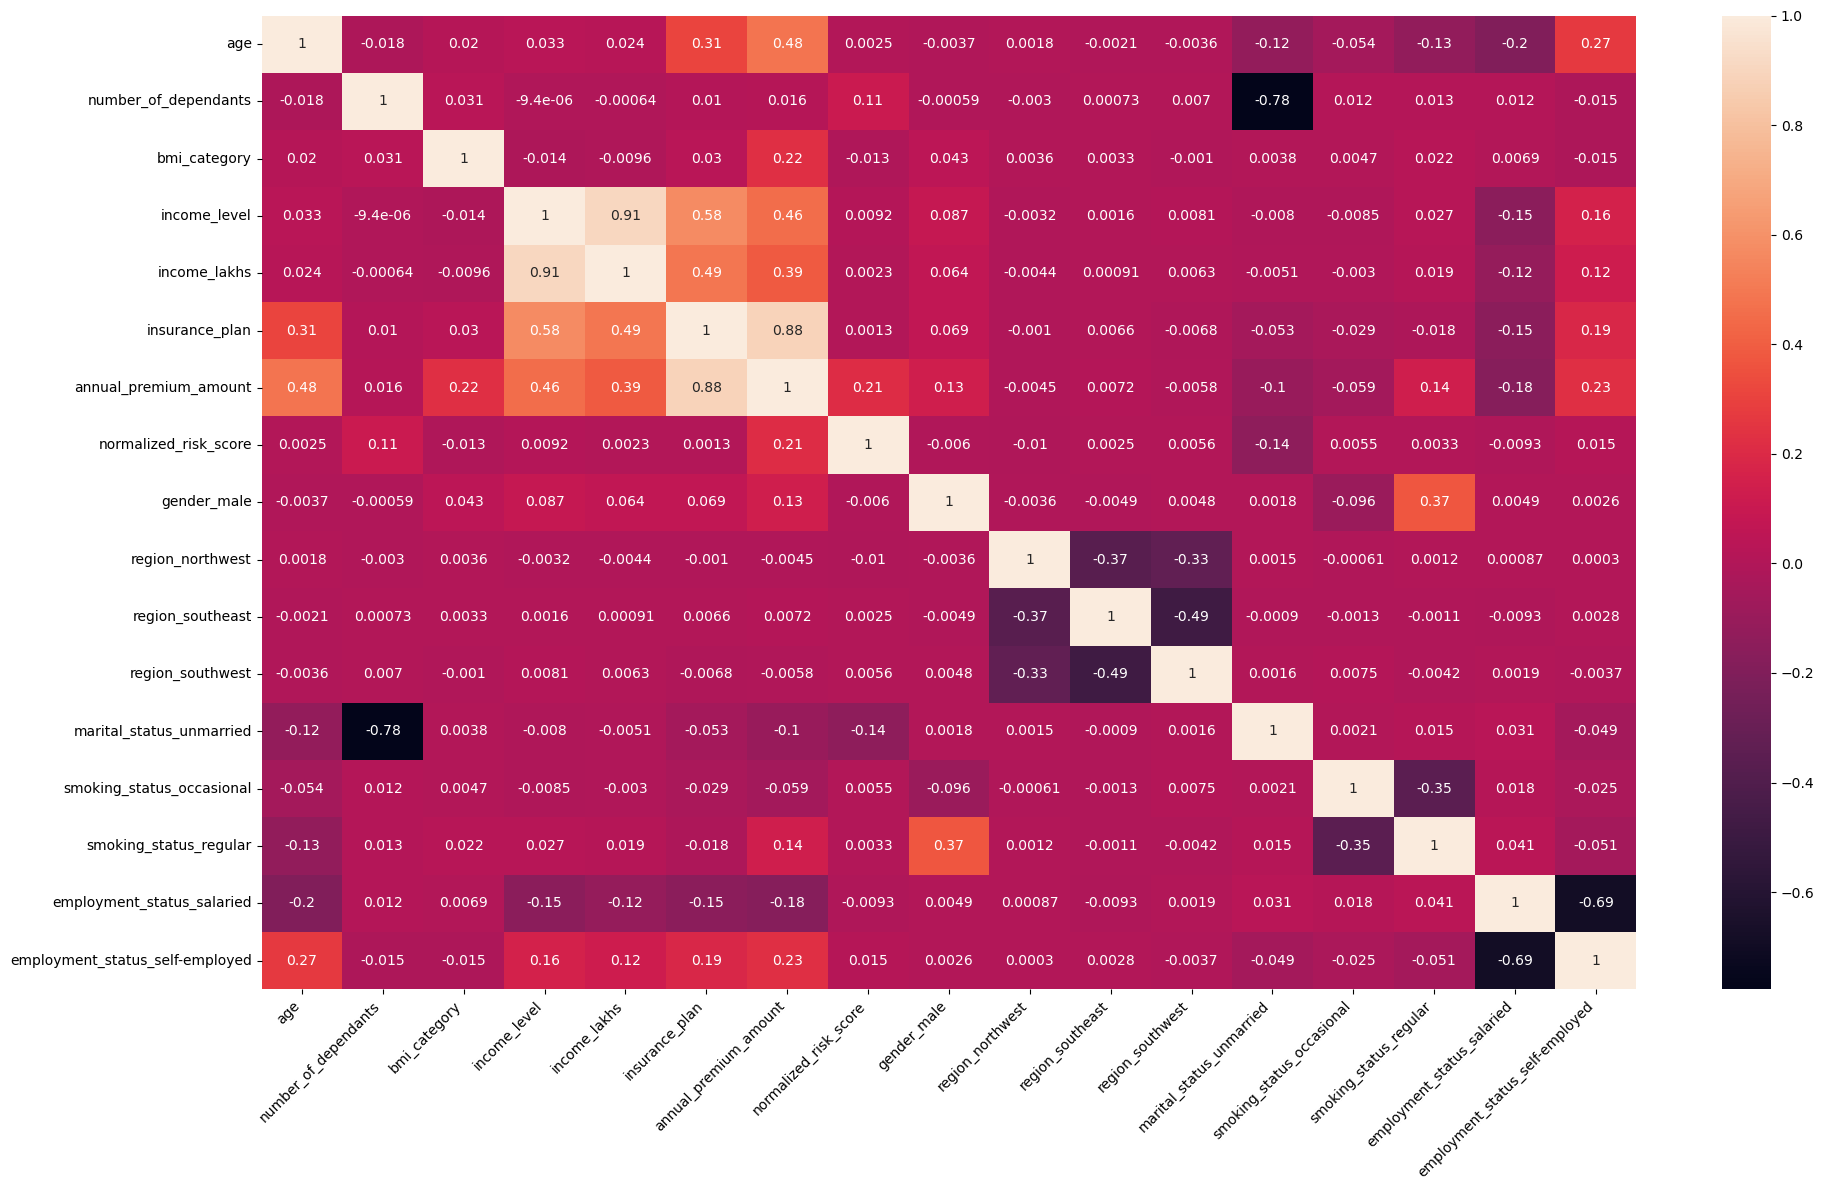

In [42]:
# Compute correlation matrix for all numerical features
cm = df4_rest.corr()

# Set figure size for better readability
plt.figure(figsize=(20,12))

# Plot heatmap with correlation coefficients
sns.heatmap(cm, annot=True)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Save figure for documentation and reproducibility
plt.savefig("../outputs/figures/premiums_rest/fe_correlation_heatmap.png", dpi=300)

# Display the heatmap
plt.show()

### Feature Scaling

In [43]:
# Separate features (X) and target variable (y)
X = df4_rest.drop('annual_premium_amount', axis='columns')
y = df4_rest['annual_premium_amount']

# Select columns to be scaled
cols_to_scale = ['age', 'number_of_dependants', 'bmi_category', 'income_level', 'income_lakhs', 'insurance_plan']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns
# This transforms all selected features to a [0, 1] range
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Display scaled feature values for verification
X.head(4)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.0,0.333333,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,1,0
1,0.065217,0.4,1.000000,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.333333,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,1,0


In [44]:
X.describe()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.526211,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.308705,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.333333,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Multicollinearity Check using Variance Inflation Factor (VIF)

In [45]:
# Function to calculate Variance Inflation Factor (VIF)
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [46]:
# Calculate VIF for all features
vif_before = calculate_vif(X)

# Display the initial VIF table
display(vif_before)

,Column,VIF
0,age,3.932259
1,number_of_dependants,6.505307
2,bmi_category,3.729844
3,income_level,13.885777
4,income_lakhs,11.186745
5,insurance_plan,5.276491
6,normalized_risk_score,3.817019
7,gender_male,2.583969
8,region_northwest,2.133461
9,region_southeast,2.994835


In [47]:
# Recalculate VIF after removing the redundant feature
vif_after = calculate_vif(X.drop('income_level', axis='columns'))
display(vif_after)

,Column,VIF
0,age,3.875128
1,number_of_dependants,6.503967
2,bmi_category,3.727653
3,income_lakhs,2.676539
4,insurance_plan,4.579307
5,normalized_risk_score,3.814411
6,gender_male,2.576369
7,region_northwest,2.132631
8,region_southeast,2.993662
9,region_southwest,2.719361


### Saving VIF Results

In [48]:
# Save VIF results to CSV files
vif_before.to_csv("../outputs/tables/rest/vif_before_reduction.csv", index=False)
vif_after.to_csv("../outputs/tables/rest/vif_after_reduction.csv", index=False)

In [49]:
# Based on results, remove 'income_level' (highly correlated with income_lakhs)
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.0,0.333333,0.050505,0.0,0.428571,1,1,0,0,1,0,0,1,0
1,0.065217,0.4,1.000000,0.050505,0.0,0.428571,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.333333,0.767677,1.0,0.000000,0,0,1,0,0,0,0,1,0
4,0.652174,0.6,1.000000,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1


In [50]:
X_reduced.shape

(29822, 15)

In [51]:
y.shape

(29822,)

# Model Training

In [52]:
# Split data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

# Display shapes of splits for verification
print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (20875, 15)
x test:  (8947, 15)
y train:  (20875,)
y test:  (8947,)


## Linear Regression Model Training

In [53]:
# Initialize and train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score, test_score

(0.9448338026820973, 0.9452579584529239)

In [54]:
y_pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression:")
print("MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression:
MSE: 2590135.3624909497 RMSE: 1609.3897484732993


In [55]:
# Display the model's intercept value
model_lr.intercept_

5082.5652057589905

In [56]:
# Display the model's coefficients
model_lr.coef_

array([ 7.06019101e+03, -1.36182423e+03,  4.34138913e+03, -7.01950409e+02,
        1.48356820e+04,  6.05438362e+03,  2.75669582e+01, -6.14253382e+01,
       -1.29365267e+01, -1.69379167e+01, -7.35371424e+02,  8.49641983e+02,
        2.79696999e+03, -3.90157121e+01,  2.67362533e+02])

In [57]:
# Extract model coefficients as feature importance
feature_importances = model_lr.coef_

# Build a dataframe of coefficients
coef_df = pd.DataFrame(feature_importances, index=X_test.columns ,columns=['Coefficients'])

# Sort coefficients from lowest to highest
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Display the DataFrame
display(coef_df)

,Coefficients
number_of_dependants,-1361.824228
marital_status_unmarried,-735.371424
income_lakhs,-701.950409
region_northwest,-61.425338
employment_status_salaried,-39.015712
region_southwest,-16.937917
region_southeast,-12.936527
gender_male,27.566958
employment_status_self-employed,267.362533
smoking_status_occasional,849.641983


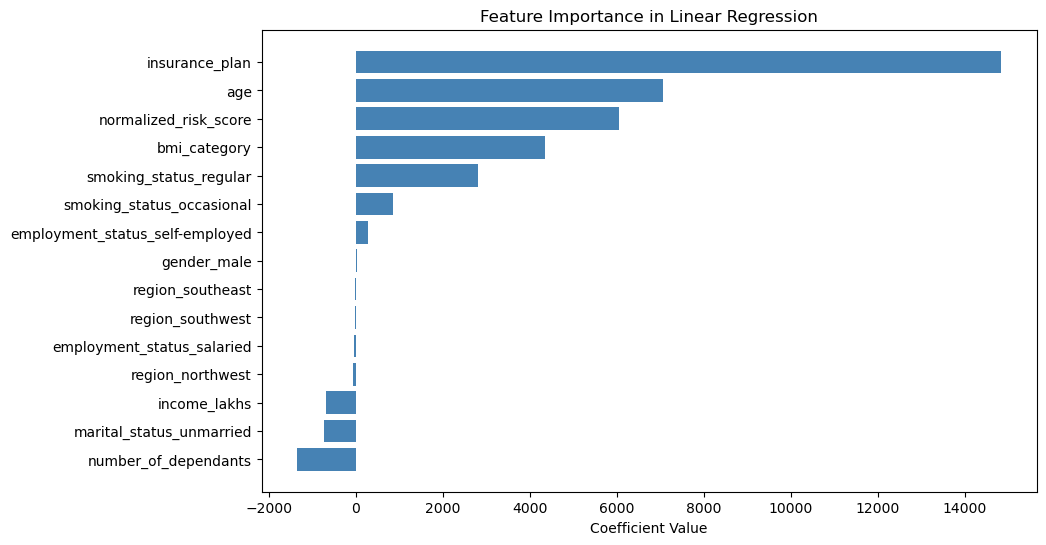

In [58]:
# Plot feature importances

plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.savefig('../outputs/figures/premiums_rest/lr_feature_importance.png', dpi=300)
plt.show()

## Ridge Regression Model Training

In [59]:
# Initialize and train the Ridge Regression model
model_rg = Ridge()
model_rg.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rg = model_rg.score(X_train, y_train)
test_score_rg = model_rg.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rg, test_score_rg

(0.9448336367200665, 0.9452597580041439)

In [60]:
y_pred_rg = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test, y_pred_rg)
rmse_rg = np.sqrt(mse_rg)
print("Ridge Regression:")
print("MSE:", mse_rg, "RMSE:", rmse_rg)

Ridge Regression:
MSE: 2590050.2162099597 RMSE: 1609.363295284803


## Random Forest Regression Model Training

In [61]:
# Initialize and train the Random Forest Regression model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rf = model_rf.score(X_train, y_train)
test_score_rf = model_rf.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rf, test_score_rf

(0.9996737091602398, 0.9976880899947206)

In [62]:
y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest Regression:")
print("MSE:", mse_rf, "RMSE:", rmse_rf)

Random Forest Regression:
MSE: 109388.68354811614 RMSE: 330.7396008162859


## XGBoost Regression Model Training

In [63]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_xgb = model_xgb.score(X_train, y_train)
test_score_xgb = model_xgb.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_xgb, test_score_xgb

(0.9986448307334327, 0.9979518351964184)

In [64]:
y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression:")
print("MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression:
MSE: 96909.50384822414 RMSE: 311.3029133307688


### Hyperparameter Tuning for XGBoost (RandomizedSearchCV)

In [65]:
# Define hyperparameter search space for XGBoost
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Randomized hyperparameter search (limited iterations for efficiency)
random_search = RandomizedSearchCV(
                model_xgb,
                param_grid,
                n_iter=10,
                cv=3,
                scoring='r2',
                random_state=42,
                n_jobs=-1)

# Fit search on training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [66]:
# Inspect best cross-validated score and parameters
print("Best CV R²:", random_search.best_score_)
print("Best Params:", random_search.best_params_)

Best CV R²: 0.9971926077167358
Best Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [67]:
# Calculate R² scores for training and testing sets
train_score_xgb_rcv = random_search.score(X_train, y_train)
test_score_xgb_rcv = random_search.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_xgb_rcv, test_score_xgb_rcv

(0.9972573321816719, 0.9971067950392661)

In [68]:
y_pred_xgb_rcv = random_search.predict(X_test)

mse_xgb_rcv = mean_squared_error(y_test, y_pred_xgb_rcv)
rmse_xgb_rcv = np.sqrt(mse_xgb_rcv)
print("XGBoost RandomizedSearchCV Regression:")
print("MSE:", mse_xgb_rcv, "RMSE:", rmse_xgb_rcv)

XGBoost RandomizedSearchCV Regression:
MSE: 136892.82072694795 RMSE: 369.9902981524623


### Model Comparison

In [69]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost", "XGBoost Randomized"],
    "Train R²": [train_score, train_score_rg, train_score_rf, train_score_xgb, train_score_xgb_rcv],
    "Test R²":  [test_score, test_score_rg, test_score_rf, test_score_xgb, test_score_xgb_rcv],
    "RMSE":     [rmse_lr, rmse_rg, rmse_rf, rmse_xgb, rmse_xgb_rcv]
})

results

,Model,Train R²,Test R²,RMSE
0,Linear Regression,0.944834,0.945258,1609.389748
1,Ridge Regression,0.944834,0.945260,1609.363295
2,Random Forest,0.999674,0.997688,330.739601
3,XGBoost,0.998645,0.997952,311.302913
4,XGBoost Randomized,0.997257,0.997107,369.990298


In [70]:
results.to_csv("../outputs/tables/rest/model_comparison.csv", index=False)

In [71]:
# Use the best estimator from the search as the final XGBoost model
best_model = random_search.best_estimator_

In [72]:
# Extract feature importances from the tuned XGBoost model
feature_importances_xgb = best_model.feature_importances_

# Build a DataFrame using training feature names
coef_df_xgb = pd.DataFrame(feature_importances_xgb, index=X_test.columns ,columns=['Coefficients'])

# Display the sorted importance table
coef_df_xgb = coef_df_xgb.sort_values(by='Coefficients', ascending=True)

# Display the DataFrame
display(coef_df_xgb)

,Coefficients
gender_male,0.000000
region_southeast,0.000000
region_southwest,0.000000
marital_status_unmarried,0.000000
employment_status_salaried,0.000007
number_of_dependants,0.000011
employment_status_self-employed,0.000015
region_northwest,0.000016
income_lakhs,0.000017
smoking_status_occasional,0.002962


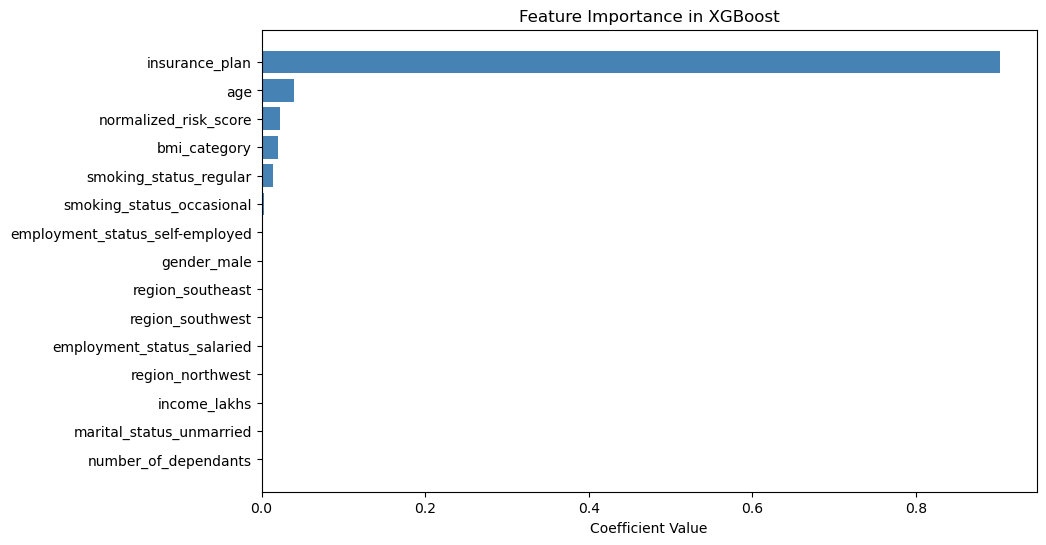

In [73]:
# Plot feature importances as a horizontal bar chart

plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df_xgb['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.savefig('../outputs/figures/premiums_rest/xgb_feature_importance.png', dpi=300)
plt.show()

The Linear Regression model showed quite an increase in the accuracy, the accuracy for the overall model was 92% but for the premium_rest data, the accuracy was 94% and the XGBoost showed an impressive accuracy of around 99%

# Error Analysis

In [74]:
# Generate predictions using the tuned model
y_pred = best_model.predict(X_test)

# Calculate raw residuals and percentage error
# diff_pct shows how far off the model is relative to actual premium
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

# Combine results into a single dataframe for easier analysis
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26624.271484,-270.728516,-1.006613
14750,22734,22639.347656,-94.652344,-0.416347
19932,21198,21459.121094,261.121094,1.231819
29643,9100,9356.307617,256.307617,2.816567
17076,26434,26624.271484,190.271484,0.719798


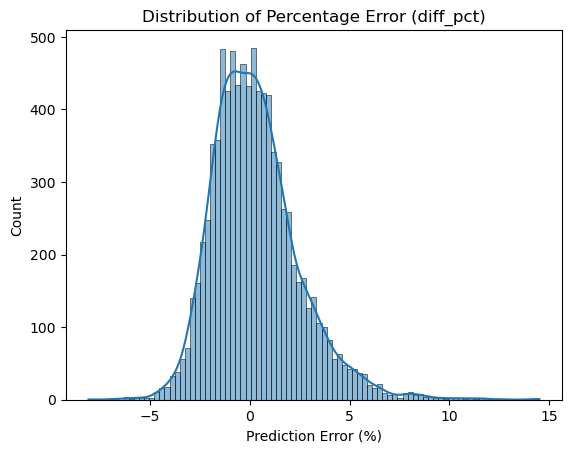

In [75]:
# Plot the distribution of percentage errors
# This reveals whether the model is consistently accurate or has dangerous outliers
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Percentage Error (diff_pct)")
plt.xlabel("Prediction Error (%)")
plt.ylabel("Count")
plt.savefig('../outputs/figures/premiums_rest/distribution_percentage_error.png', dpi=300)
plt.show()

In [76]:
# Set an error threshold (e.g., 10% is still acceptable in pricing applications)
extreme_error_threshold = 10

# Identify all predictions where the model is off by more than 10%
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(21, 4)

In [77]:
results_df.shape

(8947, 4)

In [78]:
# Compute percentage of extreme errors
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.2347155471107634

Beyond 10% threshold, we had only 21 errors and the percentage is 0.23%.

only 21 out of 8947 rows have extreme errors.
so for the age group >25, this model is working very well. So we selected the XGBoost model for the rest of the group i,e for age groups >25.

In [79]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [80]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
27518,0.304348,0.6,0.333333,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,1
7547,0.347826,0.2,0.333333,0.080808,0.0,0.000000,1,0,1,0,1,0,0,1,0
21910,0.043478,0.6,0.333333,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0
12189,0.043478,0.6,0.333333,0.060606,0.0,0.000000,1,0,0,1,0,0,0,1,0
16263,0.673913,0.6,0.333333,0.383838,0.0,0.000000,1,1,0,0,0,0,0,0,0


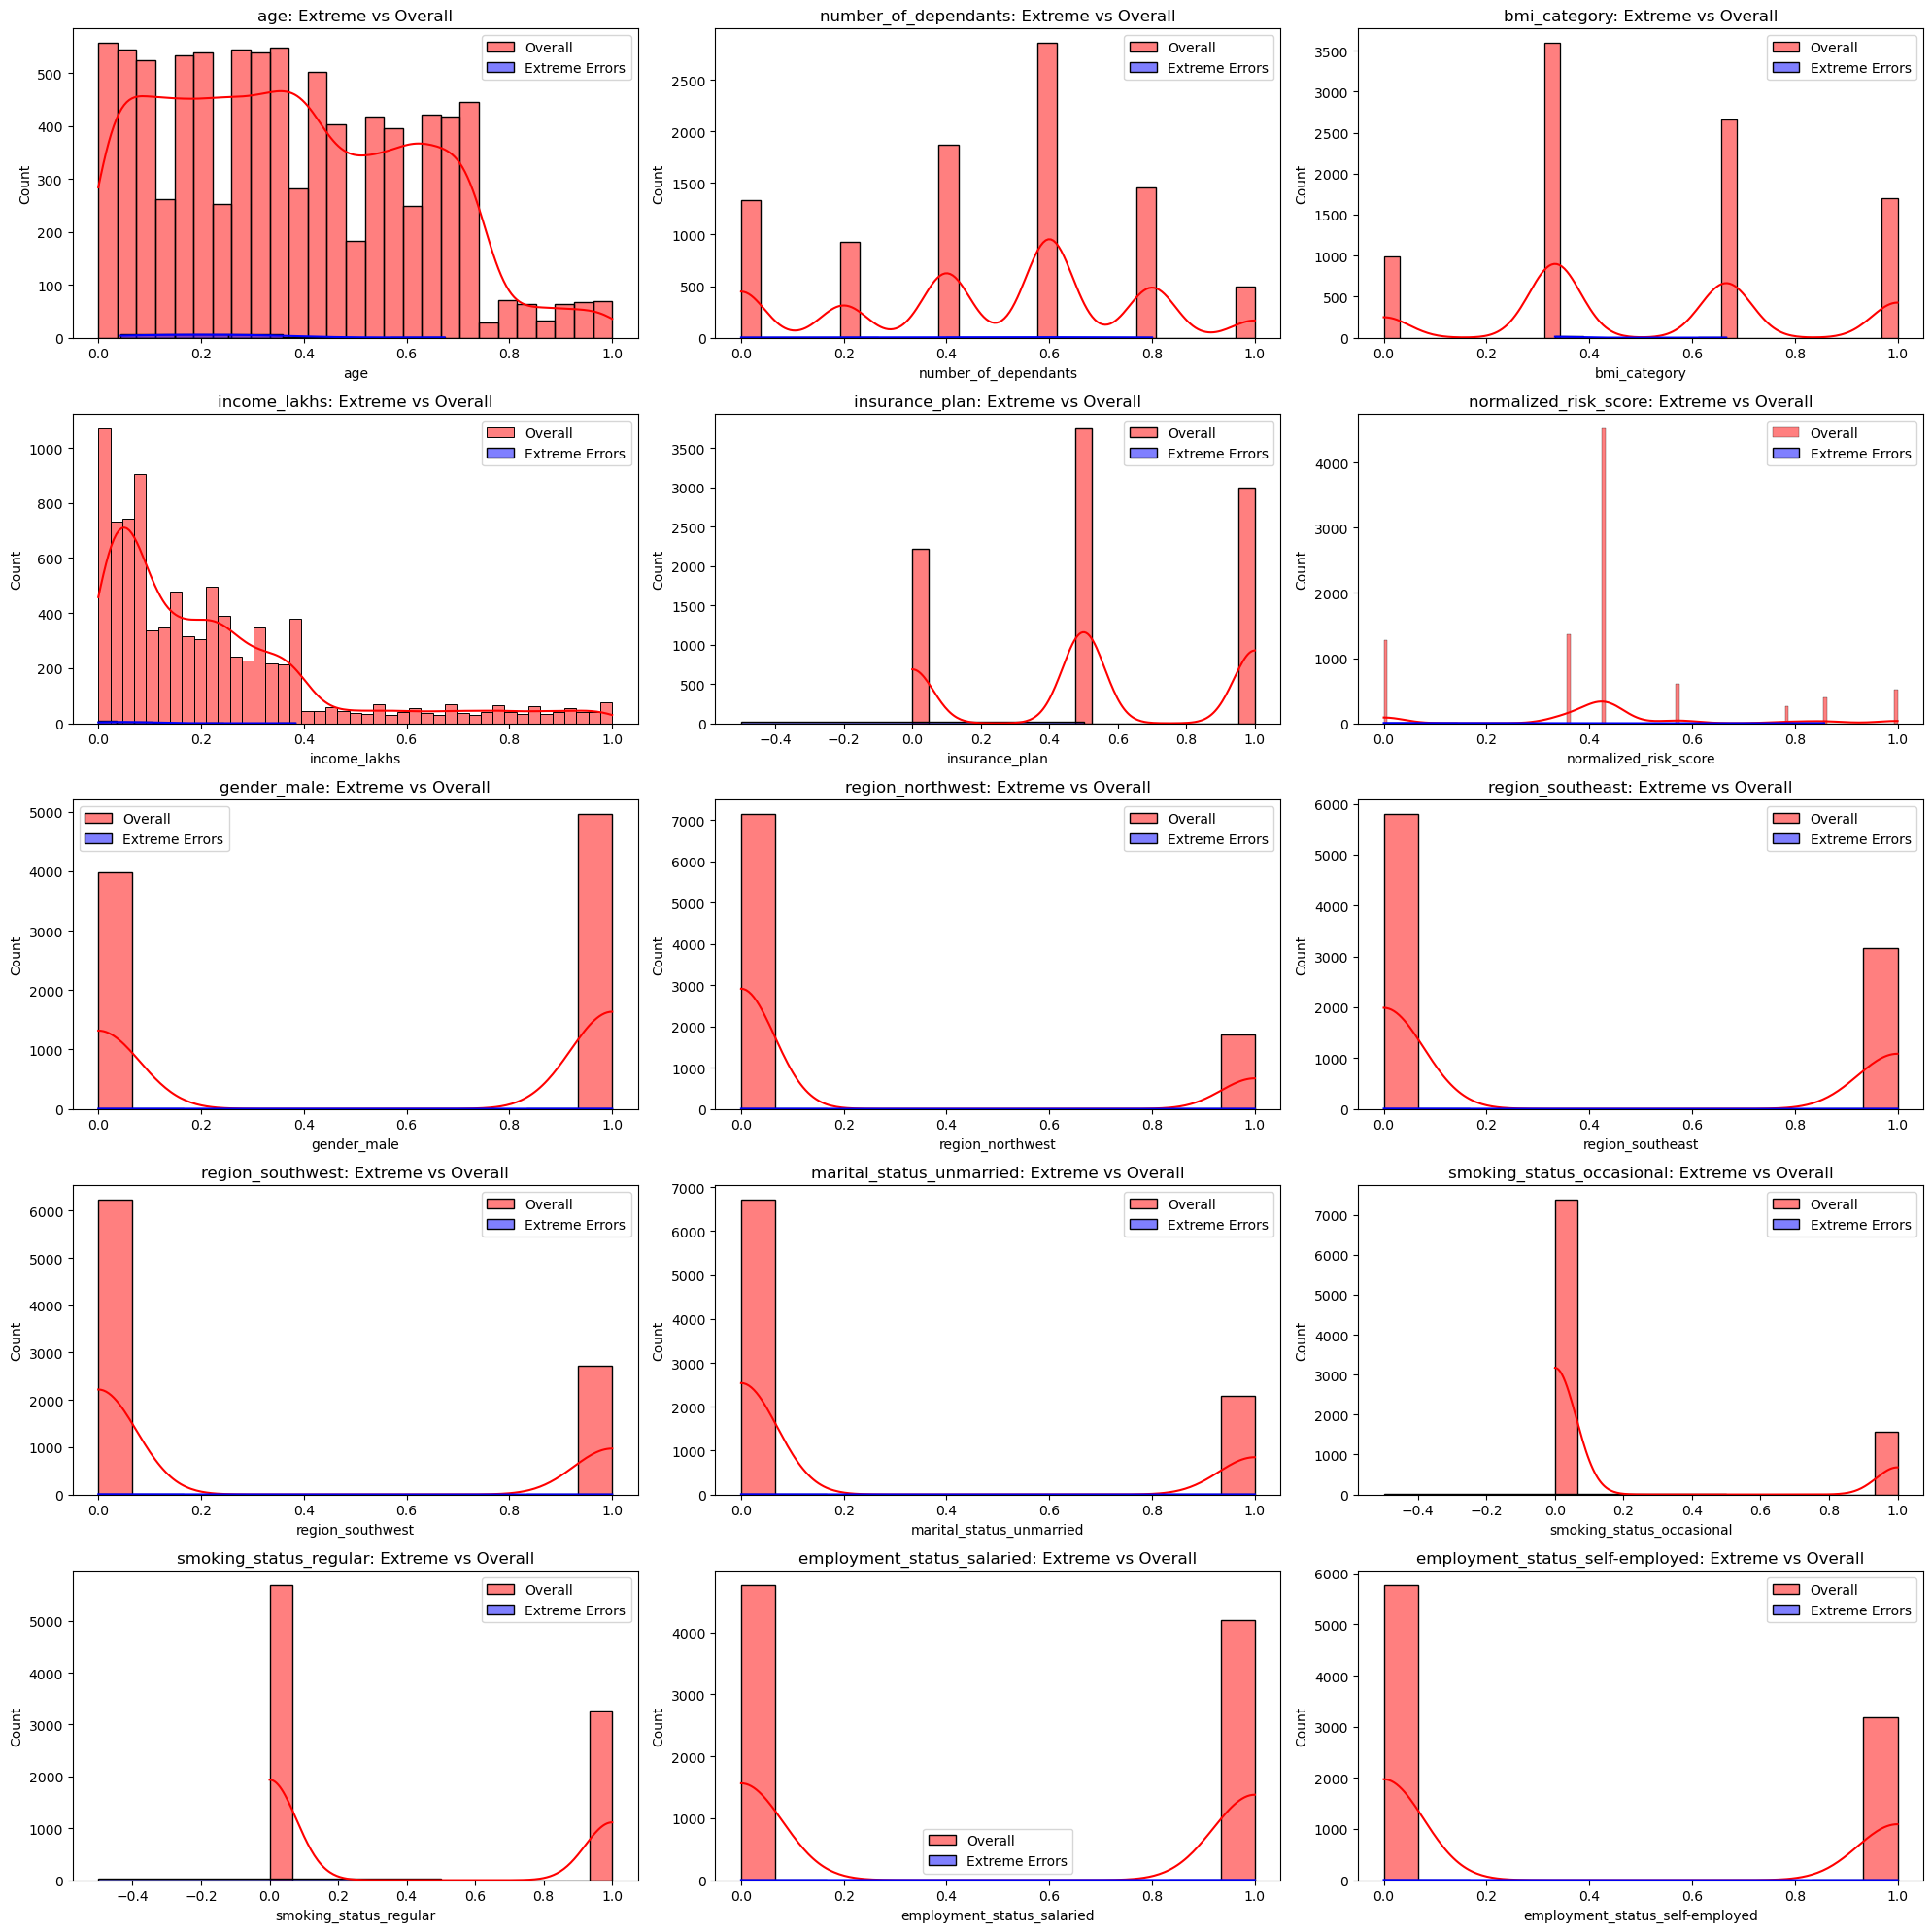

In [81]:
# Create a multi-panel figure to compare feature distributions
# for extreme-error rows vs overall test data

features = X_test.columns
n_feats = len(features)

rows = math.ceil(n_feats / 3)   # 3 plots per row
cols = 3

plt.figure(figsize=(20, rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    
    # Distribution for entire test dataset
    sns.histplot(X_test[feature], label='Overall', alpha=0.5, color='red', kde=True)
    
    # Distribution for extreme error subset
    sns.histplot(extreme_errors_df[feature], label='Extreme Errors', color='blue', kde=True)
    
    plt.title(f'{feature}: Extreme vs Overall')
    plt.legend()

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_rest/extreme_vs_overall_distributions.png", dpi=300)
plt.show()